#**유통 판매량 예측 및 재고 최적화**
## **단계1 : 데이터 탐색 및 가설 도출**

# **0.미션**

* 예측해야 할 핵심상품 역할 분담
    * 핵심상품 별로, 데이터 탐색, 가설수립, 데이터셋 구성
    * 1인당 1~2개 정도를 분담하여 개별 과제 수행
    * 팀 미팅을 통해 진행 사항 공유 및 취합

* 데이터 탐색 및 가설 도출
    * 주어진 데이터에 대해 대상 매장, 대상 상품의 그래프 그리고 시계열 패턴을 찾기
    * 찾은 패턴을 기반으로 가설 도출

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/2024.04.24_미니프로젝트6차_실습자료'

### **(2) 라이브러리 설치 및 불러오기**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

### **(3) 데이터 불러오기**

#### 1) 데이터로딩

In [4]:
oil_price = pd.read_csv(path + '/train/oil_price_train.csv')
orders = pd.read_csv(path + '/train/orders_train.csv')
sales = pd.read_csv(path + '/train/sales_train.csv')
products = pd.read_csv(path + '/train/products.csv')
stores = pd.read_csv(path + '/train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

#### 2) 기본 정보 조회

In [5]:
oil_price.head()

,Date,WTI_Price
0,2014-01-01,NaN
1,2014-01-02,95.14
2,2014-01-03,93.66
3,2014-01-06,93.12
4,2014-01-07,93.31


In [6]:
orders.head()

,Date,Store_ID,CustomerCount
0,2014-01-01,25,840
1,2014-01-01,36,487
2,2014-01-02,1,1875
3,2014-01-02,2,2122
4,2014-01-02,3,3350


In [7]:
sales.head()

,Date,Store_ID,Qty,Product_ID
0,2014-01-01,1,0.0,3
1,2014-01-01,1,0.0,5
2,2014-01-01,1,0.0,7
3,2014-01-01,1,0.0,8
4,2014-01-01,1,0.0,10


In [8]:
products.head()

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
0,20,HG001,Gardening Tools,Household Goods,2,50
1,27,HH001,Home Appliances,Household Goods,2,150
2,16,HK001,Kitchen,Household Goods,2,23
3,15,HK002,Kitchen,Household Goods,2,41
4,32,GS001,Seafood,Grocery,3,34


In [9]:
stores.head()

,Store_ID,City,State,Store_Type
0,1,Saint Paul,\tMinnesota,4
1,2,Saint Paul,\tMinnesota,4
2,3,Saint Paul,\tMinnesota,4
3,4,Saint Paul,\tMinnesota,4
4,5,Oklahoma City,Oklahoma,4


In [10]:
# 핵심 상품 별 sales 판매량 확인

sales_3_12_42 = sales[sales['Product_ID'].isin([3,12,42])]
sales_3_12_42  = sales_3_12_42.sort_values(by='Date')
sales_3_12_42.value_counts()

Date        Store_ID  Qty     Product_ID
2014-01-01  1         0.0     3             1
2016-02-10  5         3177.0  12            1
            4         3287.0  12            1
                      2232.0  3             1
            3         8061.0  3             1
                                           ..
2015-01-20  53        467.0   3             1
            52        0.0     12            1
                              3             1
            51        3990.0  12            1
2017-02-28  54        2769.0  12            1
Name: count, Length: 125571, dtype: int64

In [11]:
# 매장 ID가 44인 데이터 추출(도시, 주, 매장 유형)
stores_44 = stores[stores['Store_ID'].isin([44])]

# 매장 ID가 44인 일별 매장별 고객 방문수
orders_44 = orders[orders['Store_ID'].isin([44])]
orders_44.head()

,Date,Store_ID,CustomerCount
39,2014-01-02,44,4422
86,2014-01-03,44,4167
133,2014-01-04,44,5341
180,2014-01-05,44,5123
227,2014-01-06,44,3917


# **2.데이터 탐색**

* 시계열 패턴을 찾아보기 위한 그래프를 그려 봅시다.

## **(1) 시계열 패턴 찾아보기1**

* 다음 항목은 패턴을 찾기 위한 예제 문항 입니다. 참조하여 시계열 패턴을 찾아 봅시다.
    * 대상 매장(44), 대상 상품(3,12,42)의 판매량 추이
    * 대상 상품의 동일 카테고리의 상품별 판매량 추이
    * 휘발류 가격과 상품 판매량 추이 비교
    * 방문 고객수와 상품 판매량 추이 비교
    * 그외...

### 1) 대상 매장(44), 대상 상품의 판매량 추이

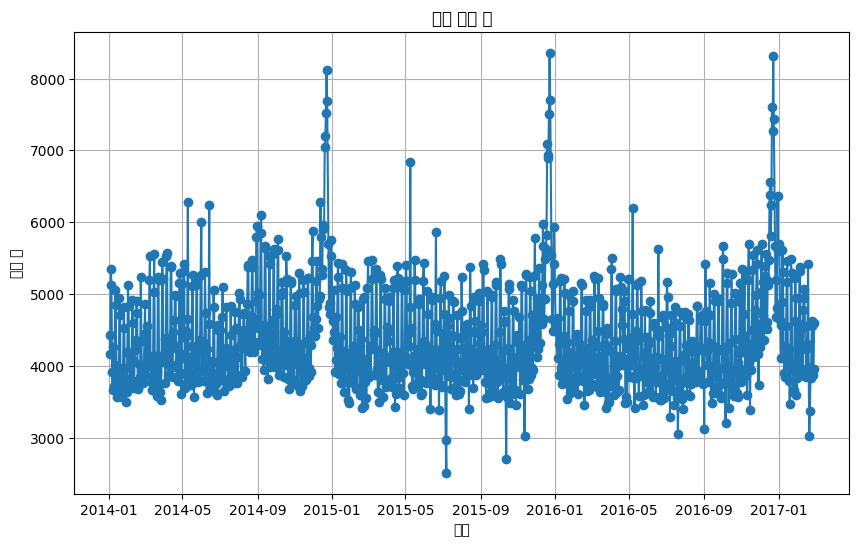

In [17]:
# 대상 매장(44)의 판매량 추이
import matplotlib.pyplot as plt
import seaborn as sns


# orders_44['Date'] = pd.to_datetime(orders_44['Date'])
# orders_44.set_index('Date', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(orders_44['CustomerCount'], marker='o', linestyle='-')
plt.title('일별 고객 수')
plt.xlabel('날짜')
plt.ylabel('고객 수')
plt.grid(True)
plt.show()

In [12]:
#3번 상품의 판매량 추이

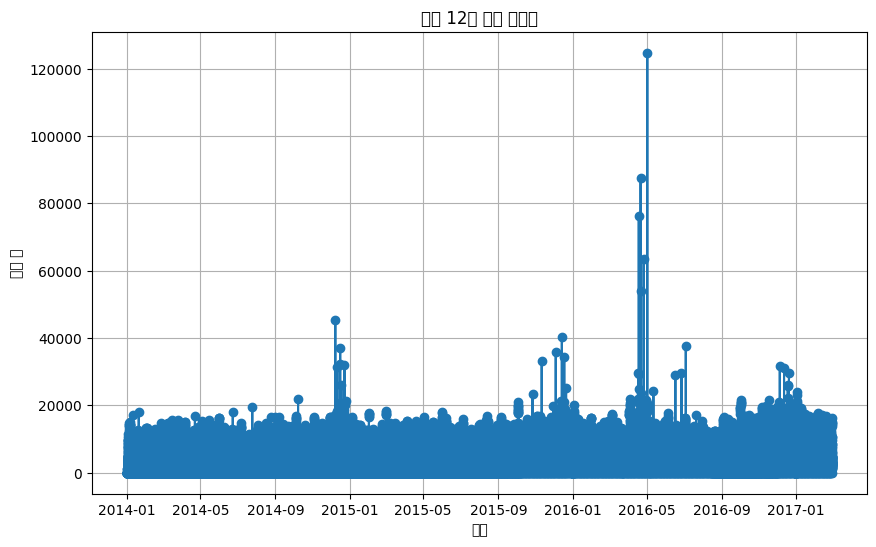

In [22]:
#12번 상품의 판매량 추이 (food)
sales_12 = sales_3_12_42[sales_3_12_42['Product_ID'].isin([12])]
sales_12 = sales_12.sort_values(by='Date')

sales_12['Date'] = pd.to_datetime(sales_12['Date'])
sales_12.set_index('Date', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(sales_12['Qty'], marker='o', linestyle='-')
plt.title('일별 12번 상품 판매량')
plt.xlabel('날짜')
plt.ylabel('고객 수')
plt.grid(True)
plt.show()

<Axes: xlabel='Month', ylabel='Qty'>

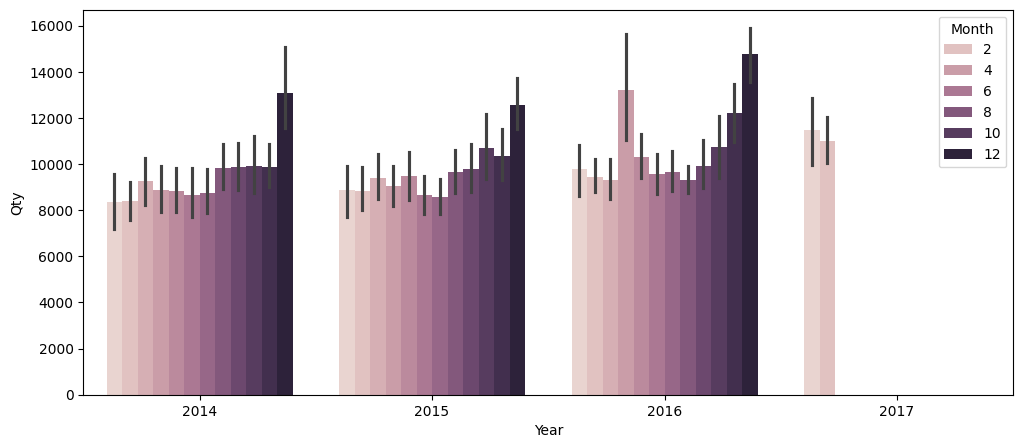

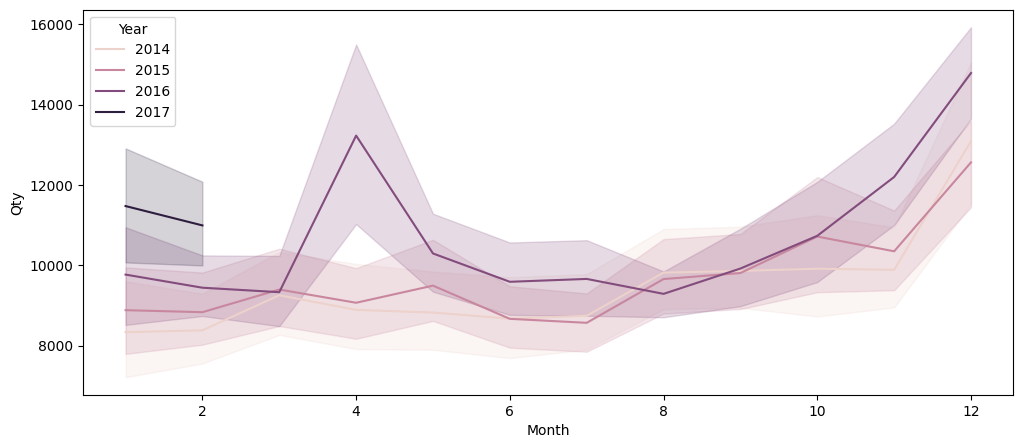

In [26]:
tgt = sales.loc[sales['Store_ID']==44].loc[sales['Product_ID']==12]
tgt['Year'] = tgt['Date'].dt.year
tgt['Month'] = tgt['Date'].dt.month
plt.figure(figsize=(12,5))
sns.barplot(tgt, x='Year', y='Qty', hue='Month')
plt.figure(figsize=(12,5))
sns.lineplot(tgt, x='Month', y='Qty', hue='Year')

In [ ]:
#42번 상품의 판매량 추이

### 2) 대상 상품의 동일 카테고리의 상품별 판매량 추이

In [12]:
#3번 상품의 동일 카테고리의 판매량 추이

In [12]:
#12번 상품의 동일 카테고리의 판매량 추이 (food)

In [24]:
product_12 = products[products['Product_ID'].isin([12])]
product_12.head()

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
14,12,GA001,Milk,Food,2,6


In [29]:
# 중분류(SubCategory = Milk) 중분류는 밀크 단독이다 즉 12번 상품의 추이랑 똑같음
prodcut_milk = products[products['SubCategory'].isin(['Milk'])]
prodcut_milk.head()

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
14,12,GA001,Milk,Food,2,6


In [32]:
prodcut_food_ = products[products['Category'].isin(['Food'])]
prodcut_food_.head()

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
6,29,FP001,Prepared,Food,2,18
7,11,FF001,Frozen,Food,2,29
10,5,FB001,BAKERY,Food,2,6
11,8,FM001,Yogurt,Food,2,4
14,12,GA001,Milk,Food,2,6


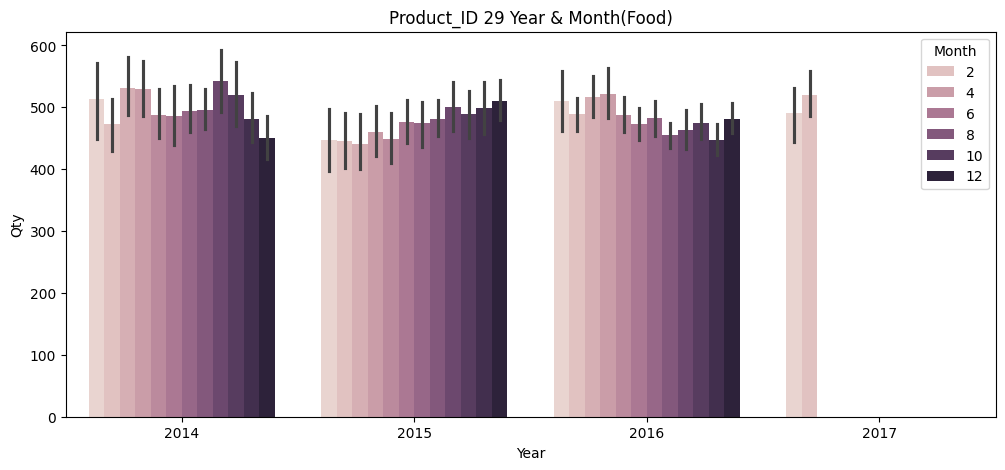

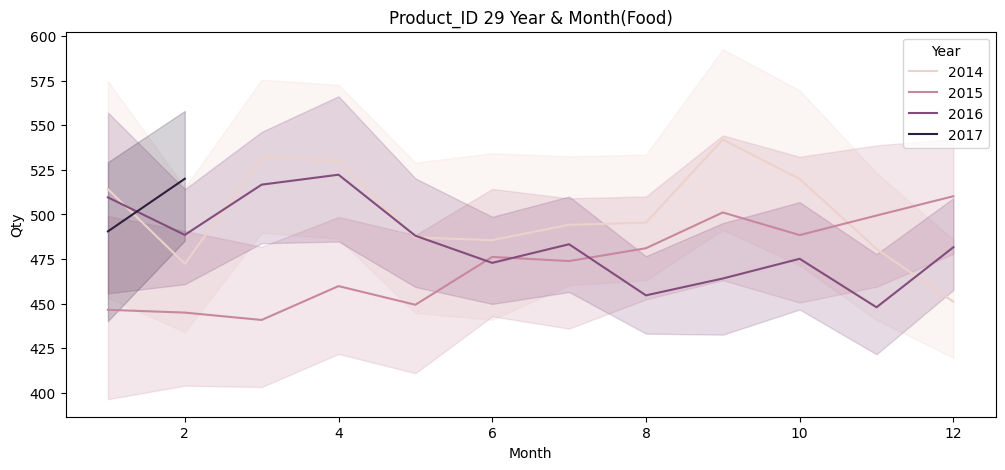

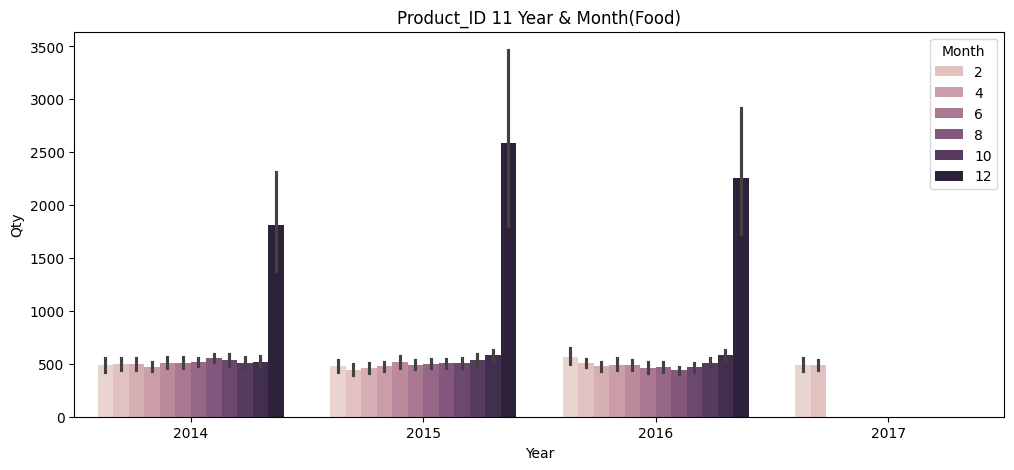

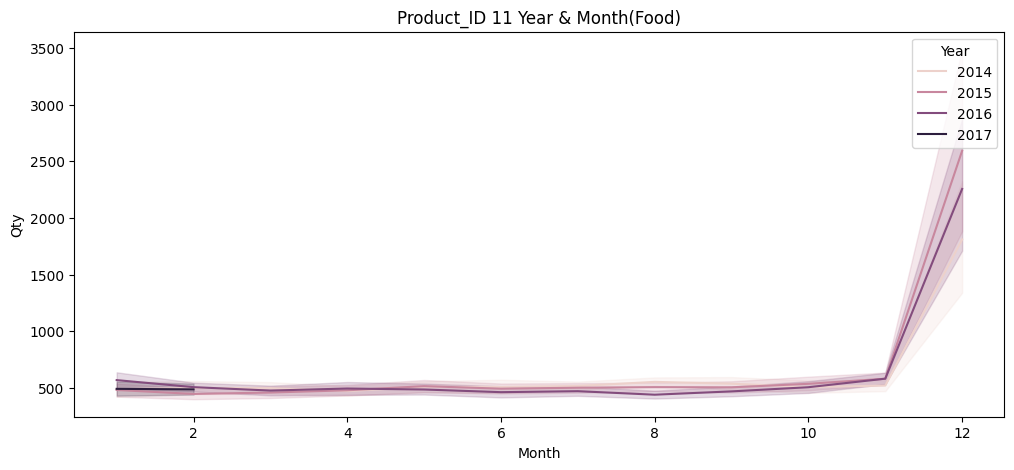

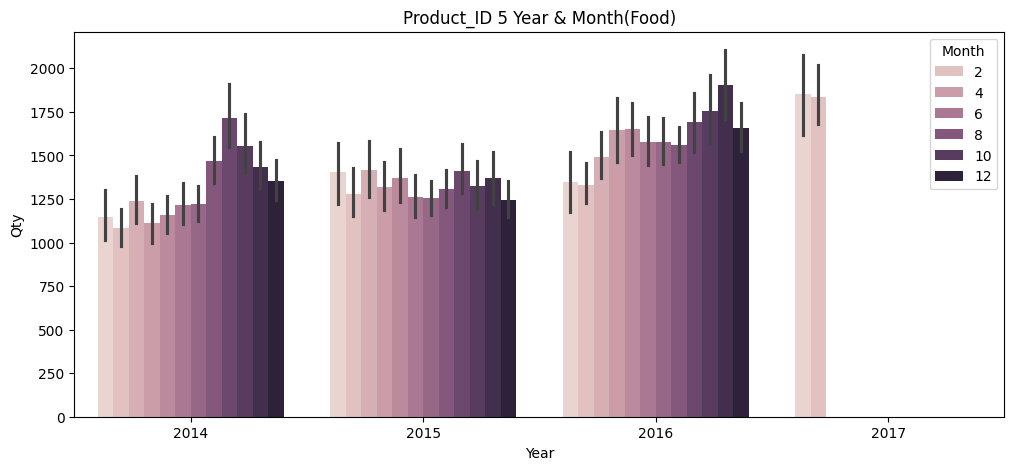

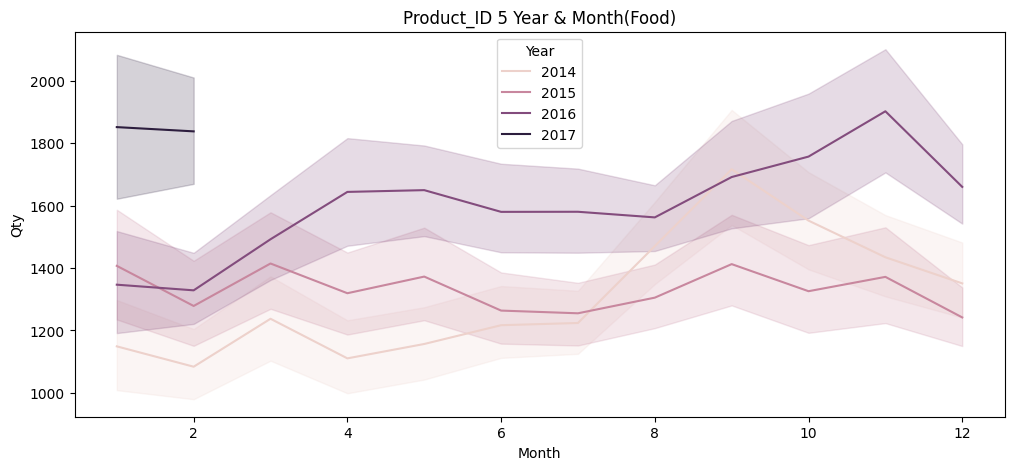

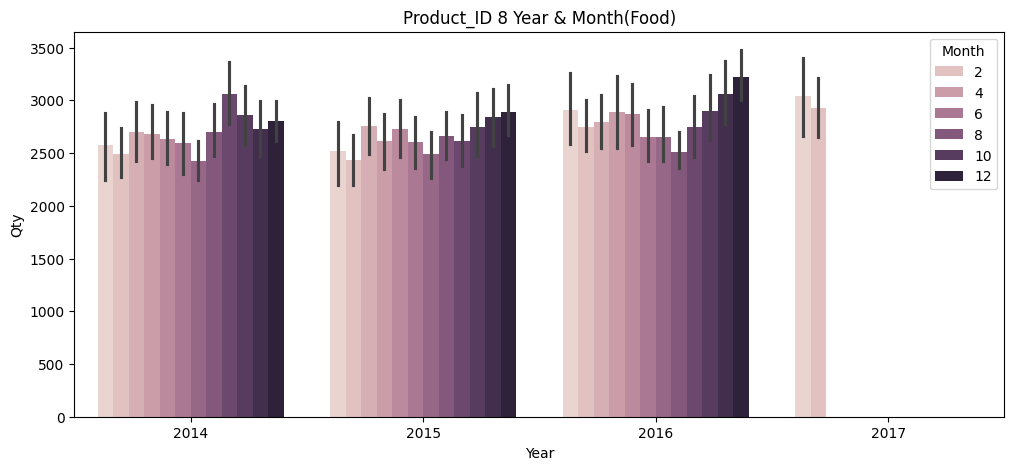

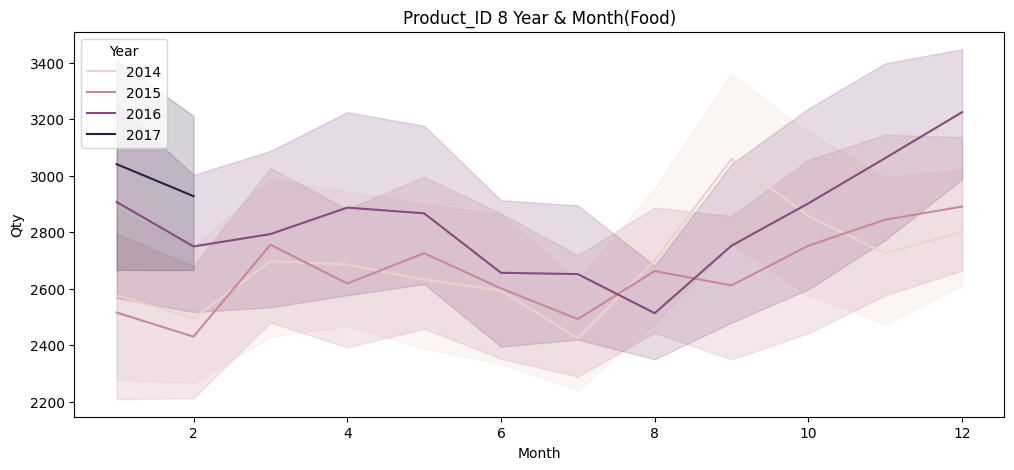

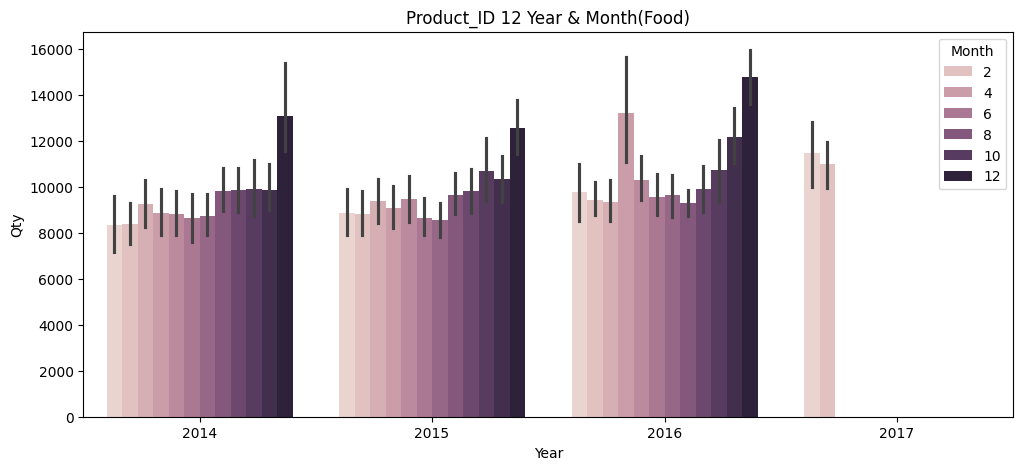

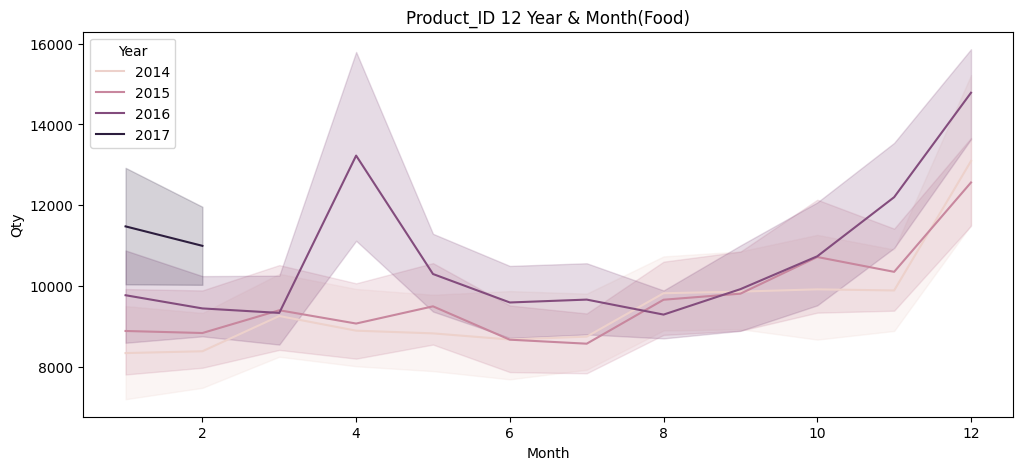

In [31]:
# 대분류(Category = Food)

product_food = products.loc[products['Category'] == 'Food', 'Product_ID'].unique()

# 각 Product_ID에 대한 그래프 그리기
for product_id in product_food:

    tgt = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == product_id)]
    tgt['Year'] = tgt['Date'].dt.year
    tgt['Month'] = tgt['Date'].dt.month

    plt.figure(figsize=(12, 5))
    sns.barplot(data=tgt, x='Year', y='Qty', hue='Month')
    plt.title(f'Product_ID {product_id} Year & Month(Food)')
    plt.xlabel('Year')
    plt.ylabel('Qty')
    plt.show()

    plt.figure(figsize=(12, 5))
    sns.lineplot(data=tgt, x='Month', y='Qty', hue='Year')
    plt.title(f'Product_ID {product_id} Year & Month(Food)')
    plt.xlabel('Month')
    plt.ylabel('Qty')
    plt.show()


In [ ]:
# 이 매장에서만 잘 팔리는 것인가?

In [12]:
#42번 상품의 동일 카테고리의 판매량 추이

### 3) 휘발류 가격과 상품 판매량 추이 비교

In [80]:
# 휘발류 주말 가격 추가
import datetime

oil_price['dayWeek'] = oil_price['Date'].dt.day_name()

new_oil_price = pd.DataFrame({
    'Date' : [0],
    'WTI_Price' : [0],
    'dayWeek' : [0]
})

n=0
for i in range(len(oil_price)):
    new_oil_price.loc[i+n] = oil_price.loc[i]
    if oil_price['dayWeek'].loc[i]==4:
        new_oil_price.loc[i+n+1] = [oil_price['Date'].loc[i]+ datetime.timedelta(days=1), oil_price['WTI_Price'].loc[i], 5]
        new_oil_price.loc[i+n+2] = [oil_price['Date'].loc[i]+ datetime.timedelta(days=2), oil_price['WTI_Price'].loc[i], 6]
        n+=2

new_oil_price['Date'] = pd.to_datetime(new_oil_price['Date'] )
new_oil_price.head(10)

,Date,WTI_Price,dayWeek
0,2014-01-01,NaN,Wednesday
1,2014-01-02,95.14,Thursday
2,2014-01-03,93.66,Friday
3,2014-01-06,93.12,Monday
4,2014-01-07,93.31,Tuesday
5,2014-01-08,91.90,Wednesday
6,2014-01-09,91.36,Thursday
7,2014-01-10,92.39,Friday
8,2014-01-13,91.45,Monday
9,2014-01-14,92.15,Tuesday


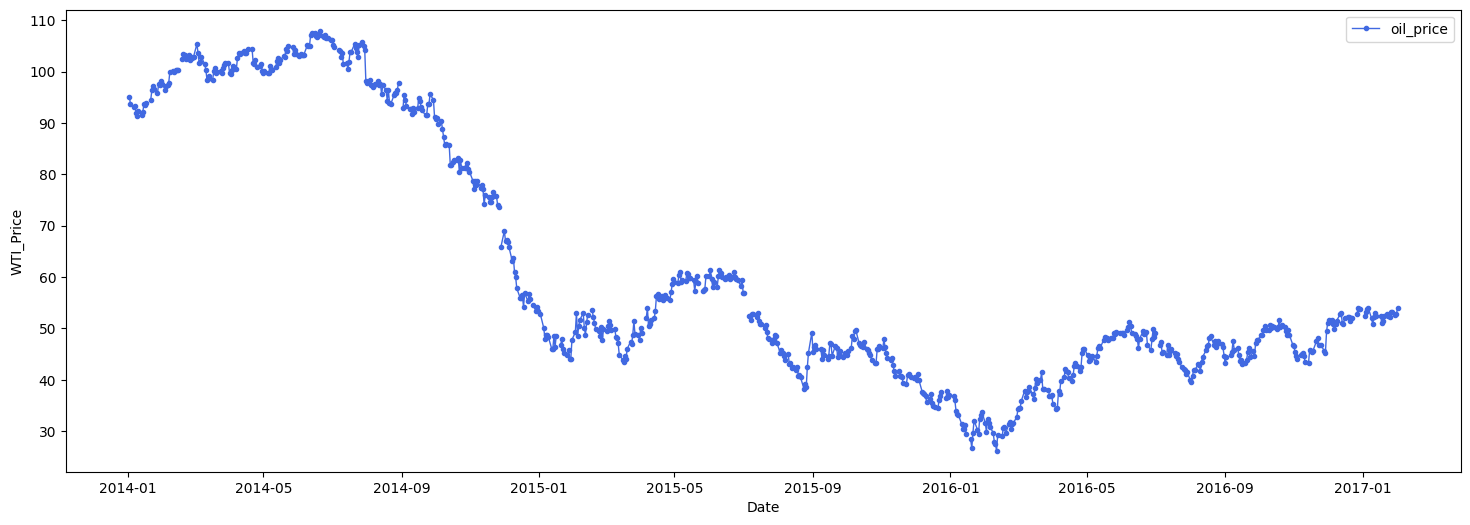

In [88]:
# 유가 가격 추이

def check_period_oil(oil_price, sdate, edate):

    temp = oil_price.loc[(oil_price['Date'].between(sdate, edate))]
    monday_data = temp[temp['dayWeek'] == 0]
    plt.figure(figsize=(18, 6))
    plt.plot(temp['Date'].to_list(), temp['WTI_Price'], 'o-', ms=3, lw=1, label='oil_price', color='royalblue')      # ms: 마크크기, lw: 라인 굵기
    plt.scatter(monday_data['Date'].to_list(), monday_data['WTI_Price'], color='red')
    plt.xlabel('Date')                  #x축 이름
    plt.ylabel('WTI_Price')            #y축 이름
    plt.legend()
    plt.show()

check_period_oil(new_oil_price, '2014-01', '2017-02')

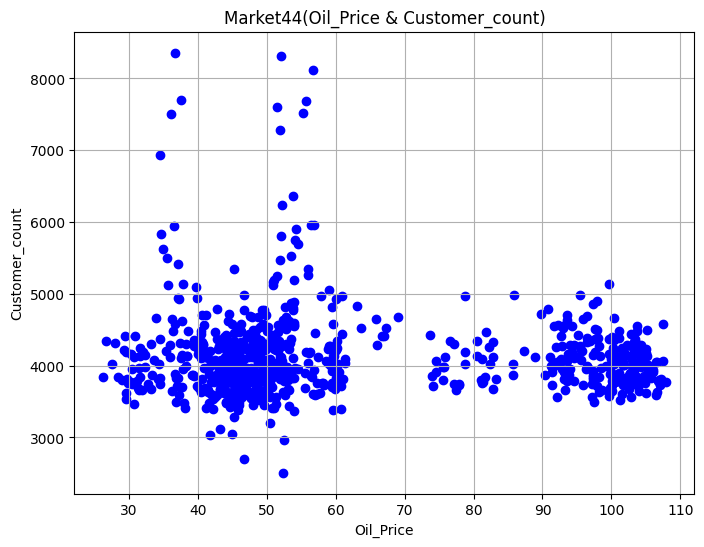

In [85]:
# 휘발류 가격과 매장 방문 손님 수와의 연관성

merged_data = pd.merge(new_oil_price, orders_44,how = 'left', on='Date')

# 산점도 그래프 그리기
plt.figure(figsize=(8, 6))
plt.scatter(merged_data['WTI_Price'], merged_data['CustomerCount'], color='blue')
plt.title('Market44(Oil_Price & Customer_count)')
plt.xlabel('Oil_Price')
plt.ylabel('Customer_count')
plt.grid(True)
plt.show()

In [12]:
# 휘발류 가격과 3,12,42 사이의 연관성

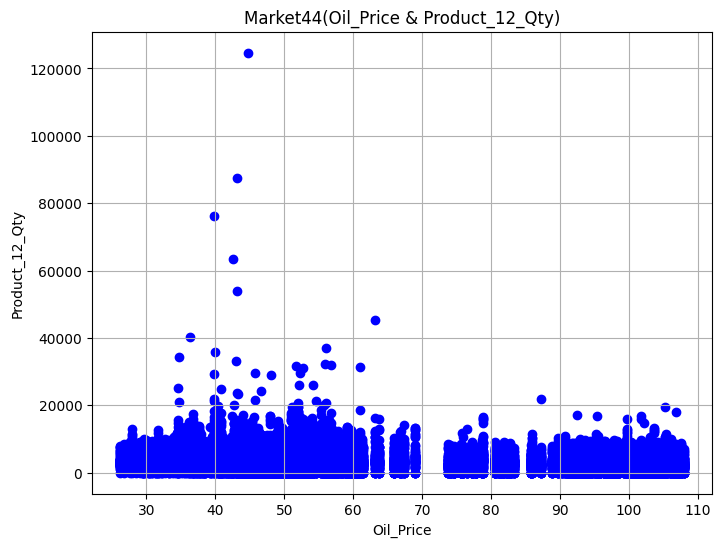

In [86]:
# 휘발류 가격과 12 판매수량 사이의 연관성

merged_data_12 = pd.merge(new_oil_price, sales_12, how = 'left',on='Date')

# 산점도 그래프 그리기
plt.figure(figsize=(8, 6))
plt.scatter(merged_data_12['WTI_Price'], merged_data_12['Qty'], color='blue')
plt.title('Market44(Oil_Price & Product_12_Qty)')
plt.xlabel('Oil_Price')
plt.ylabel('Product_12_Qty')
plt.grid(True)
plt.show()

### 4) 방문 고객수와 상품 판매량 추이 비교

In [12]:
# 매장 방문 수와 3,12,42 사이의 연관성

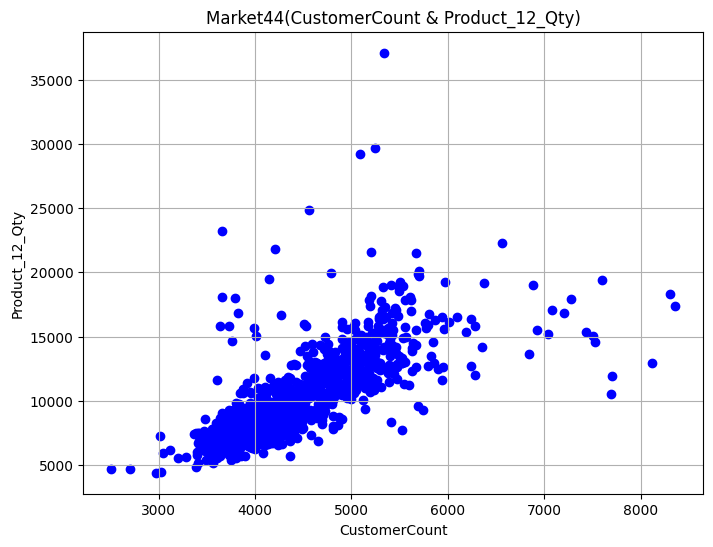

In [70]:
# 매장(44번) 방문 수와 12번 제품과의 연관성

merged_data_sale_customer_12 = pd.merge(orders_44, sales_12, how = 'left', on=['Date','Store_ID'])
# 산점도 그래프 그리기
plt.figure(figsize=(8, 6))
plt.scatter(merged_data_sale_customer_12['CustomerCount'], merged_data_sale_customer_12['Qty'], color='blue')
plt.title('Market44(CustomerCount & Product_12_Qty)')
plt.xlabel('CustomerCount')
plt.ylabel('Product_12_Qty')
plt.grid(True)
plt.show()

## **(2) 시계열 패턴 찾아보기2**

* 변화량과 비교해보기

### 1) 대상 매장(44), 대상 상품의 판매량 추이

### 2) 요일별 변화량 비교

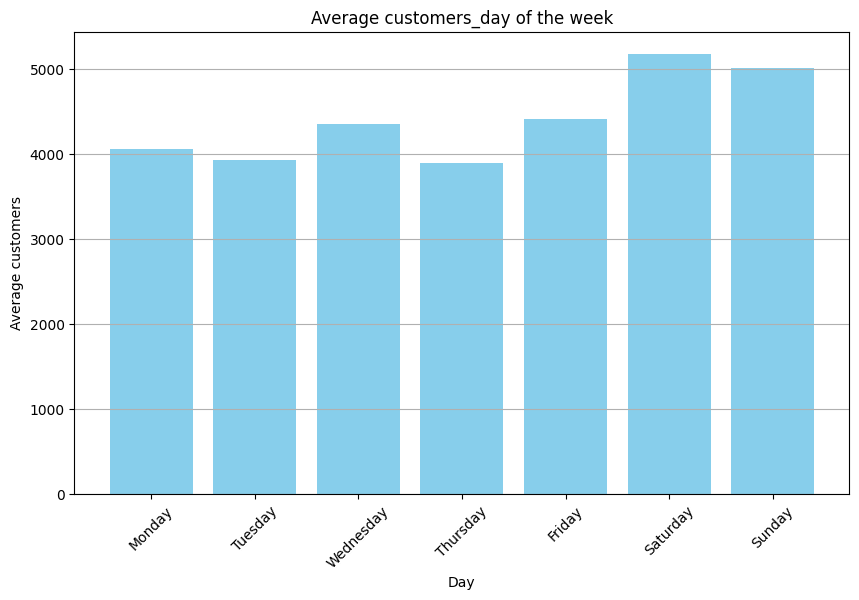

In [46]:
# 요일별 매장(44) 방문 수

orders_44.head()

orders_44['Day_of_Week'] = orders_44.index.day_name()
daily_customer_count = orders_44.groupby('Day_of_Week')['CustomerCount'].mean()
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))
plt.bar(ordered_days, daily_customer_count[ordered_days], color='skyblue')
plt.title('Average customers_day of the week')
plt.xlabel('Day')
plt.ylabel('Average customers')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

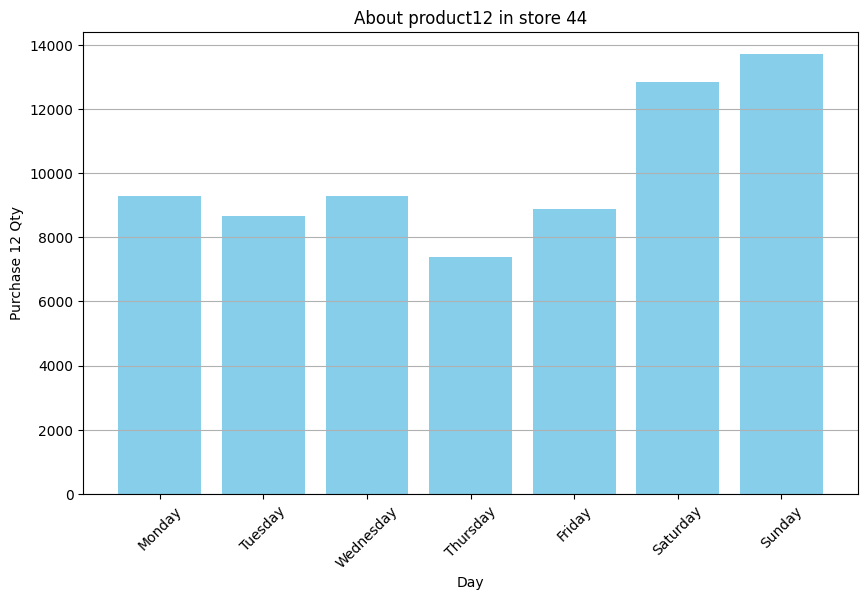

In [59]:
# 요일별 12번 제품 구매 빈도 수
# 44번 매장에 12번 제품에 대하여

sales_12_44 = sales_12[sales_12['Store_ID'].isin([44])]
sales_12_44.head()

sales_12_44['Day_of_Week'] = sales_12_44.index.day_name()
daily_customer_count = sales_12_44.groupby('Day_of_Week')['Qty'].mean()
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))
plt.bar(ordered_days, daily_customer_count[ordered_days], color='skyblue')
plt.title('About product12 in store 44')
plt.xlabel('Day')
plt.ylabel('Purchase 12 Qty')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### 3) 시계열 데이터 분해

In [13]:
def decomp_plot(Product_ID, sdate, edate, period ) :
    # period = 7이면 일주일 간 반복패턴
    # 잔차분석 할 수 있으면 해라
    # 시계열 데이터 분해
    temp = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]
    decomp = sm.tsa.seasonal_decompose(temp['Qty'], model = 'additive', period = period)

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})

    # 4개의 그래프로 나눠서 그리기
    plt.figure(figsize=(15, 8))

    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')

    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')

    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')

    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

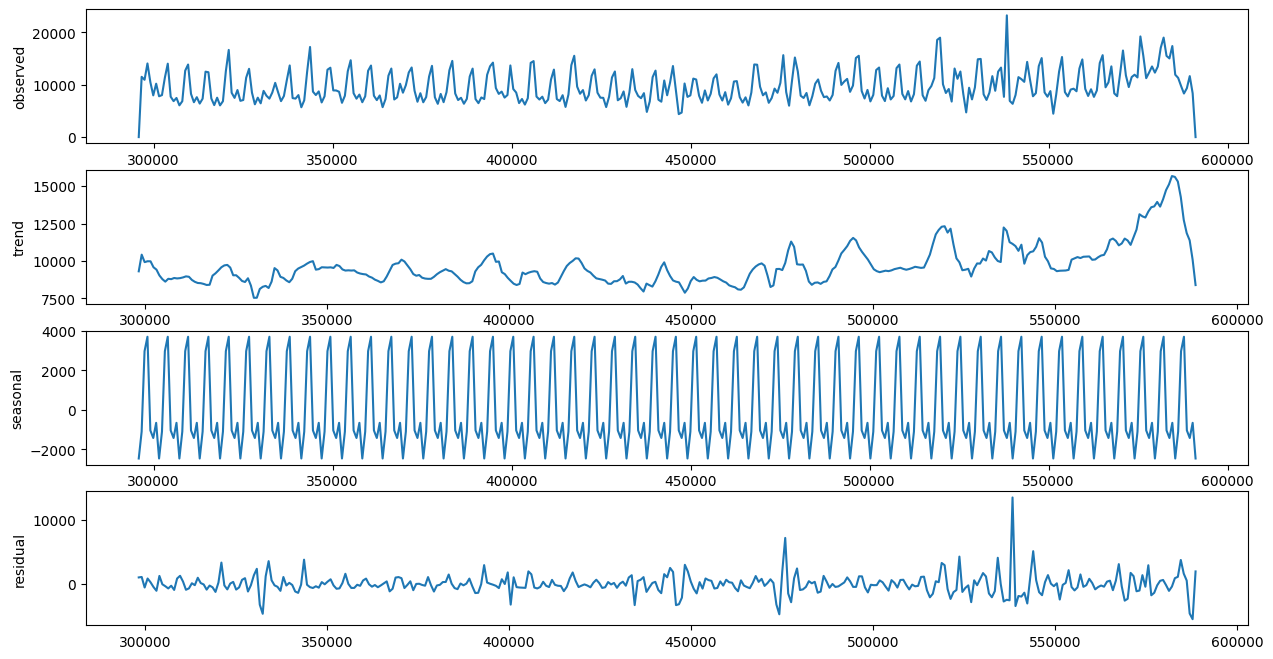

,observed,trend,seasonal,residual
295856,0.0,NaN,-2462.779160,NaN
296667,11505.0,NaN,-1102.014972,NaN
297478,10939.0,NaN,2974.856176,NaN
298289,14052.0,9305.714286,3706.905413,1039.380301
299100,10488.0,10418.714286,-1037.808125,1107.093840
...,...,...,...,...
587817,8319.0,10089.350714,3706.905413,-5477.256127
588628,9323.0,8388.285714,-1037.808125,1972.522411
589439,11642.0,NaN,-1423.467328,NaN
590250,8360.0,NaN,-655.692003,NaN


In [73]:
decomp_plot(12, '2015-01-01', '2016-01-01', 7)

### 4) 그 외 패턴 찾아보기

In [84]:
# # 44번과 같은 도시:'Saint Paul'

# stores_sp = stores[stores['City'].isin(['Saint Paul'])]
# stores_sp

In [ ]:
def decomp_plot(Product_ID, sdate, edate, period ) :
    # period = 7이면 일주일 간 반복패턴
    # 잔차분석 할 수 있으면 해라
    # 시계열 데이터 분해
    temp = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]
    decomp = sm.tsa.seasonal_decompose(temp['Qty'], model = 'additive', period = period)

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})

    # 4개의 그래프로 나눠서 그리기
    plt.figure(figsize=(15, 8))

    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')

    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')

    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')

    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

# **3.패턴 정리하기**

* 다양한 탐색을 통해 찾은 시계열 패턴을 적어 봅시다.

In [13]:
# 휘발유 가격이 낮아질수록 판매량이 높아진다.
# 주말(토,일)에 판매량이 높아진다.
# 고객 수가 많아질수록 판매량이 높아진다.